In [1]:
from model import *
from data import *
from torch.optim import Adam, lr_scheduler

Load Data

In [2]:
bs = 64
train_data, train_labels, val_data, val_labels = get_data()
training_set = Dataset(train_data, train_labels)
val_set = Dataset(val_data, val_labels)
training_generator = torch.utils.data.DataLoader(training_set, batch_size = bs, shuffle = True, num_workers = 6)
val_generator = torch.utils.data.DataLoader(val_set, batch_size = bs, shuffle = True, num_workers = 6)

Initialize the Model

In [3]:
model = baseline()
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr = .1)
lrs = lr_scheduler.LinearLR(optimizer, total_iters=25)

Training Procedure

Epoch: 0 Train Loss 1.0037220051744953 Val Loss: 1.0041733717080206
Train Acc: 0.5058083576998051 Val Acc: 0.5124635214007782
Epoch: 1 Train Loss 1.002220336929895 Val Loss: 1.0032861926592886
Train Acc: 0.5062408625730994 Val Acc: 0.5127742650237787
Epoch: 2 Train Loss 1.0021808671299368 Val Loss: 1.003573196940124
Train Acc: 0.5097587719298247 Val Acc: 0.5126188932122784
Epoch: 3 Train Loss 1.001969818433281 Val Loss: 1.0080936485901475
Train Acc: 0.5075109649122806 Val Acc: 0.5119974059662776
Epoch: 4 Train Loss 1.002738400187809 Val Loss: 1.0038370955735445
Train Acc: 0.5067708333333333 Val Acc: 0.5127742650237787
Epoch: 5 Train Loss 1.0023121115518734 Val Loss: 1.0041443300433457
Train Acc: 0.5056621588693958 Val Acc: 0.5123081495892781
Epoch: 6 Train Loss 1.0021262637455948 Val Loss: 1.0047008339315653
Train Acc: 0.5070815058479532 Val Acc: 0.5124635214007782
Epoch: 7 Train Loss 1.002396861789748 Val Loss: 1.005260669393465
Train Acc: 0.507285575048733 Val Acc: 0.4880025940337225

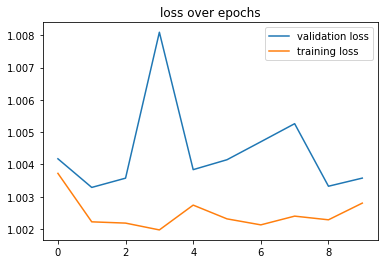

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#Record to plot later
epoch_train = []
epoch_val = []
for epoch in range(10):

    running_loss = 0
    val_loss = 0
    train_acc = []
    val_acc = []

    #Main Training Procedure
    for local_batch, local_labels in training_generator:

        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        optimizer.zero_grad()
        outputs = torch.squeeze(model(local_batch))
        loss = criterion(outputs, local_labels)
        loss.backward()
        optimizer.step()
        lrs.step()

        train_acc.append(np.mean(((outputs.data.cpu().numpy() - local_labels.data.cpu().numpy())**2 < .25)))
        running_loss += loss.item() / (4*bs)

    #Validation Proceudre
    for local_batch, local_labels in val_generator:

        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = torch.squeeze(model(local_batch))
        loss = criterion(outputs, local_labels)

        val_acc.append(np.mean(((outputs.data.cpu().numpy() - local_labels.data.cpu().numpy())**2 < .25)))
        val_loss += loss.item() / bs

    print('Epoch:', epoch, 'Train Loss', running_loss, 'Val Loss:', val_loss)
    print('Train Acc:', np.mean(np.array(train_acc)), 'Val Acc:', np.mean(np.array(val_acc)))
    epoch_train.append(running_loss)
    epoch_val.append(val_loss)

plt.figure()
plt.title('loss over epochs')
plt.plot(epoch_val, label=f'validation loss')
plt.plot(epoch_train, label=f'training loss')
plt.legend()
plt.show()


Test outputs

In [7]:
torch.squeeze(model(torch.randn(10, 1, 2)))

tensor([0.4812, 0.4798, 0.4807, 0.4820, 0.4798, 0.4800, 0.4814, 0.4857, 0.4804,
        0.4815], grad_fn=<SqueezeBackward0>)